In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
os.listdir('food-101/images')

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [3]:
os.listdir('food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

In [4]:
# Visualize the data, showing one image per class from 101 classes
'''
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html
'''

'\nrows = 17\ncols = 6\nfig, ax = plt.subplots(rows, cols, figsize=(25,25))\nfig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue\ndata_dir = "food-101/images/"\nfoods_sorted = sorted(os.listdir(data_dir))\nfood_id = 0\nfor i in range(rows):\n  for j in range(cols):\n    try:\n      food_selected = foods_sorted[food_id] \n      food_id += 1\n    except:\n      break\n    if food_selected == \'.DS_Store\':\n        continue\n    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category\n    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item\n    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))\n    ax[i][j].imshow(img)\n    ax[i][j].set_title(food_selected, pad = 10)\n    \nplt.s

In [5]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [6]:
#prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

In [7]:
#prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

In [8]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [9]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [10]:
print("Creating train data folder with new classes")
#dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes


In [11]:
print("Creating test data folder with new classes")
#dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes


In [12]:
K.clear_session()
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = 'train'
validation_data_dir ='test'
nb_train_samples = 5750
nb_validation_samples = 5250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

food_list = train_generator.class_indices
print(food_list)
predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=150,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 

359/359 [==============================] - 913s 3s/step - loss: 3.4641 - accuracy: 0.3419 - val_loss: 2.8893 - val_accuracy: 0.4716
Epoch 21/150
359/359 [==============================] - ETA: 0s - loss: 3.4606 - accuracy: 0.3367
Epoch 21: val_loss improved from 2.88933 to 2.80791, saving model to best_model_3class.hdf5
359/359 [==============================] - 912s 3s/step - loss: 3.4606 - accuracy: 0.3367 - val_loss: 2.8079 - val_accuracy: 0.4829
Epoch 22/150
359/359 [==============================] - ETA: 0s - loss: 3.3445 - accuracy: 0.3607
Epoch 22: val_loss improved from 2.80791 to 2.72735, saving model to best_model_3class.hdf5
359/359 [==============================] - 923s 3s/step - loss: 3.3445 - accuracy: 0.3607 - val_loss: 2.7273 - val_accuracy: 0.4968
Epoch 23/150
359/359 [==============================] - ETA: 0s - loss: 3.2892 - accuracy: 0.3713
Epoch 23: val_loss improved from 2.72735 to 2.64679, saving model to best_model_3class.hdf5
359/359 [=========================

Epoch 73/150
359/359 [==============================] - ETA: 0s - loss: 1.9021 - accuracy: 0.6346
Epoch 73: val_loss did not improve from 1.39610
359/359 [==============================] - 952s 3s/step - loss: 1.9021 - accuracy: 0.6346 - val_loss: 1.4119 - val_accuracy: 0.7409
Epoch 74/150
359/359 [==============================] - ETA: 0s - loss: 1.8450 - accuracy: 0.6569
Epoch 74: val_loss improved from 1.39610 to 1.38814, saving model to best_model_3class.hdf5
359/359 [==============================] - 943s 3s/step - loss: 1.8450 - accuracy: 0.6569 - val_loss: 1.3881 - val_accuracy: 0.7439
Epoch 75/150
359/359 [==============================] - ETA: 0s - loss: 1.8719 - accuracy: 0.6374
Epoch 75: val_loss did not improve from 1.38814
359/359 [==============================] - 943s 3s/step - loss: 1.8719 - accuracy: 0.6374 - val_loss: 1.4055 - val_accuracy: 0.7407
Epoch 76/150
359/359 [==============================] - ETA: 0s - loss: 1.8297 - accuracy: 0.6535
Epoch 76: val_loss did n

Epoch 101/150
359/359 [==============================] - ETA: 0s - loss: 1.6199 - accuracy: 0.6884
Epoch 101: val_loss did not improve from 1.19705
359/359 [==============================] - 965s 3s/step - loss: 1.6199 - accuracy: 0.6884 - val_loss: 1.2293 - val_accuracy: 0.7746
Epoch 102/150
359/359 [==============================] - ETA: 0s - loss: 1.6440 - accuracy: 0.6858
Epoch 102: val_loss did not improve from 1.19705
359/359 [==============================] - 967s 3s/step - loss: 1.6440 - accuracy: 0.6858 - val_loss: 1.2174 - val_accuracy: 0.7761
Epoch 103/150
359/359 [==============================] - ETA: 0s - loss: 1.6185 - accuracy: 0.6905
Epoch 103: val_loss improved from 1.19705 to 1.18486, saving model to best_model_3class.hdf5
359/359 [==============================] - 968s 3s/step - loss: 1.6185 - accuracy: 0.6905 - val_loss: 1.1849 - val_accuracy: 0.7883
Epoch 104/150
359/359 [==============================] - ETA: 0s - loss: 1.6074 - accuracy: 0.6966
Epoch 104: val_lo

359/359 [==============================] - 954s 3s/step - loss: 1.4119 - accuracy: 0.7333 - val_loss: 1.1155 - val_accuracy: 0.7881
Epoch 129/150
359/359 [==============================] - ETA: 0s - loss: 1.3881 - accuracy: 0.7389
Epoch 129: val_loss did not improve from 1.09462
359/359 [==============================] - 959s 3s/step - loss: 1.3881 - accuracy: 0.7389 - val_loss: 1.1032 - val_accuracy: 0.7986
Epoch 130/150
359/359 [==============================] - ETA: 0s - loss: 1.4131 - accuracy: 0.7322
Epoch 130: val_loss improved from 1.09462 to 1.09327, saving model to best_model_3class.hdf5
359/359 [==============================] - 955s 3s/step - loss: 1.4131 - accuracy: 0.7322 - val_loss: 1.0933 - val_accuracy: 0.8001
Epoch 131/150
359/359 [==============================] - ETA: 0s - loss: 1.4124 - accuracy: 0.7302
Epoch 131: val_loss improved from 1.09327 to 1.08008, saving model to best_model_3class.hdf5
359/359 [==============================] - 955s 3s/step - loss: 1.4124 -

In [13]:
model.save('model_trained_3class.h5')

In [14]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


{'loss': [5.212760925292969, 5.141761302947998, 5.097724437713623, 5.0461812019348145, 4.980964660644531, 4.909420967102051, 4.805636405944824, 4.721372604370117, 4.624734401702881, 4.5151190757751465, 4.389565467834473, 4.273379802703857, 4.168185234069824, 4.059381008148193, 3.9504826068878174, 3.8534557819366455, 3.7508816719055176, 3.6683907508850098, 3.562589406967163, 3.464142322540283, 3.4605705738067627, 3.344510316848755, 3.289219617843628, 3.202177047729492, 3.137359380722046, 3.094313859939575, 3.053603172302246, 3.00264573097229, 2.9402973651885986, 2.8773586750030518, 2.840471029281616, 2.7982757091522217, 2.7577781677246094, 2.740583658218384, 2.6895782947540283, 2.658629894256592, 2.588155746459961, 2.5699455738067627, 2.537703514099121, 2.5341992378234863, 2.484457015991211, 2.462059497833252, 2.4509212970733643, 2.407242774963379, 2.411875009536743, 2.353457450866699, 2.3320255279541016, 2.3180432319641113, 2.298083543777466, 2.278377056121826, 2.231860399246216, 2.213

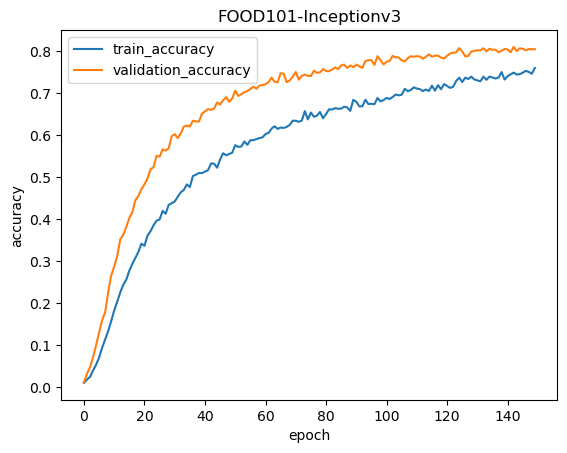

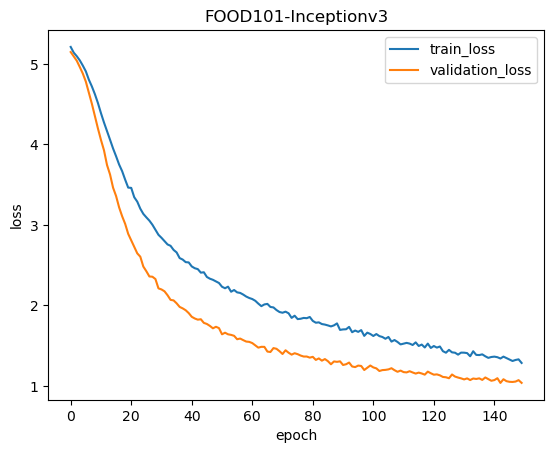

In [15]:
print(history.history)
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')


In [16]:
K.clear_session()
model_best = load_model('ALGO_Food_Classfication_best_model.hdf5',compile = False)

In [17]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
#food_list = food_list.keys()
print(list(food_list))
predict_class(model_best, images, True)